Emotion Recognition Classification Task. My Emotion Data Set:

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

train.csv contains two columns, "emotion" and "pixels". The "emotion" column contains a numeric code ranging from 0 to 6, inclusive, for the emotion that is present in the image. The "pixels" column contains a string surrounded in quotes for each image. The contents of this string a space-separated pixel values in row major order. test.csv contains only the "pixels" column and your task is to predict the emotion column.

The training set consists of 28,709 examples. The public test set used for the leaderboard consists of 3,589 examples. The final test set, which was used to determine the winner of the competition, consists of another 3,589 examples.

- What did you learn from exploring the data that will influence how you approach modelling this dataset?
- How did you process/pre-process the data (note it may be different for different models)
- Data Augmentation: You don’t have that much data, employ different data augmentation strategies, to help your training.
- Standard ML Baseline: Create a simple baseline of your choice using standard ML
- Deep NN models: Create a deep NN, and find a good configuration (explore at least 5-10 configurations)
- Complex NN Models: Rather than employing a standard deep NN model, this is your chance to use more sophisticated architectures. For example, CNNs, ResNet, etc.  to improve performance.

Try to find interesting architectures that might help improve the performance. They must be different architectures (not just extra layers). Include the mean and standard deviations. Include the results with and without your different training schedules (i.e. with/without different data augmentation)



In [170]:
import pandas as pd
import sklearn as sklearn
from sklearn.linear_model import Perceptron
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [171]:
# load dataset
data = pd.read_csv('C:\\Users\\annal\\OneDrive\\Dokumente\\Year Two\\Machine Learning\\my_emotion_train.csv')

In [172]:
# Shape of the dataset
# Display the first few rows
# Summary statistics for the dataset
# Checking for missing values

print("Shape of the dataset:", data.shape)

print("First few rows of the dataset:")
print(data.head())

print("Summary statistics for the dataset:")
print(data.describe(include='all'))

print("Missing values in the dataset:")
print(data.isnull().sum())

Shape of the dataset: (29000, 3)
First few rows of the dataset:
      id  emotion                                             pixels
0   9415        6  29 16 18 18 18 20 19 18 17 17 17 18 17 18 17 1...
1  19109        3  126 154 167 181 188 194 195 194 196 195 198 20...
2  21523        2  169 220 218 208 184 144 72 73 143 183 203 210 ...
3   2076        3  60 64 72 80 83 83 80 82 89 106 114 125 125 127...
4  13957        3  174 148 121 97 78 70 62 57 54 54 42 58 40 64 1...
Summary statistics for the dataset:
                  id       emotion  \
count   29000.000000  29000.000000   
unique           NaN           NaN   
top              NaN           NaN   
freq             NaN           NaN   
mean    17909.302759      3.321828   
std     10363.556419      1.871095   
min         0.000000      0.000000   
25%      8922.500000      2.000000   
50%     17911.500000      3.000000   
75%     26869.250000      5.000000   
max     35885.000000      6.000000   

                             

In [173]:
# Separate the target variable ('emotion') and predictors ('pixels')
# At this point, 'X' contains only the 'pixels' data, and 'y' contains the 'emotion' labels.
# keep the 'ID' column for later reference

X = data['pixels'].copy()
y = data['emotion'].copy()
id = data['id'].copy()

In [174]:

# Convert 'pixels' from a string to a 2D numpy array and normalize the pixel values
data['pixels'] = data['pixels'].apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape(48, 48) / 255.0)


In [175]:
# Now, create a 4D array (for TensorFlow) where each image has shape (48, 48, 1) indicating height, width, and channel
X = np.stack(data['pixels'].values).reshape(-1, 48, 48, 1)  

In [176]:
X.shape

(29000, 48, 48, 1)

In [177]:
y.shape

(29000,)

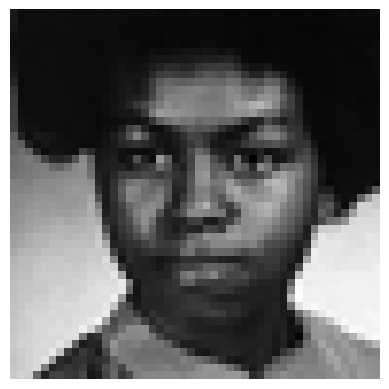

In [178]:
# To see what the image that we are classifying looks like
image = data['pixels'].iloc[0]
plt.imshow(image, cmap='gray')
plt.axis('off') 
plt.show()

Build, train, and evaluate a simple Wide & Deep neural network model using TensorFlow's Keras API. Creating a class which will then construct and instantiate a model.  

In [179]:
# Firstly, we need to consider how we would like to adjust our labels for the target variable. We can either:
# a) one hot encode the Labels as it is multi-class classification, as each instance can only belong to one class, or;
# a) we can use sparse labels, which is more efficient for computational time, but some activation functions are not compatable with this, where as they may be with one hot encoded labels
# If we decide to encode, use: y = tf.keras.utils.to_categorical(y, num_classes=7)

# # Creating a class which will then construct and instantiate a model. DNN incorporating Batch Normalisation
# Dense layers often have a lot of parameters. This gives the model quite a lot of flexibility to fit the training data, but it also means that the model runs the risk of
# overfitting, especially when you do not have a lot of training data. 

# Example configurations to explore, now including optimizers in the configurations
configurations = [
    {'units': 30, 'activation': 'relu', 'epochs': 20, 'optimizer': keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)}
]

class BatchNormModel(keras.Model):
    def __init__(self, input_shape, num_classes, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.norm_layer = keras.layers.Normalization(axis=-1)
        self.dense1 = keras.layers.Dense(units, use_bias=False)
        self.bn1 = keras.layers.BatchNormalization()
        self.act1 = keras.layers.Activation(activation)
        self.dense2 = keras.layers.Dense(units, use_bias=False)
        self.bn2 = keras.layers.BatchNormalization()
        self.act2 = keras.layers.Activation(activation)
        self.flatten = keras.layers.Flatten()
        self.output_layer = keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.norm_layer(inputs)
        x = self.dense1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.dense2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.flatten(x)
        return self.output_layer(x)

def run_config(X, y, config, val_size=0.2):
    # Split the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, random_state=42)
    
    # Create a new model instance with the current configuration
    model = BatchNormModel(input_shape=X_train.shape[1:], num_classes=np.unique(y).size, units=config['units'], activation=config['activation'])
    
    # Use the specified optimizer from the configuration
    model.compile(optimizer=config['optimizer'], loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Adapt normalization layer
    model.norm_layer.adapt(X_train)

    # Train the model
    history = model.fit(X_train, y_train, epochs=config['epochs'], validation_data=(X_val, y_val), verbose=2)
    
    return history

# Run through each configuration
for config in configurations:
    history = run_config(X, y, config)
    val_accuracy = history.history['val_accuracy'][-1]
    print(f"Configuration: {config}, Validation Accuracy: {val_accuracy}")

In [180]:
# Assuming X and y are defined
from sklearn.preprocessing import StandardScaler

# Example for image data: Scale each channel individually
scaler = StandardScaler()

# Assume X is shaped as (samples, height, width, channels)
# Reshape to (samples * height * width, channels) for scaling
X_reshaped = X.reshape(-1, X.shape[-1])
X_scaled_reshaped = scaler.fit_transform(X_reshaped)

# Reshape back to original shape
X = X_scaled_reshaped.reshape(X.shape)

In [181]:
import keras_tuner as kt

class BatchNormModel(keras.Model):
    def __init__(self, input_shape, num_classes, units, activation="relu", **kwargs):
        super().__init__(**kwargs)
        # Removed the normalization layer
        self.dense1 = keras.layers.Dense(units, use_bias=False)
        self.bn1 = keras.layers.BatchNormalization()
        self.act1 = keras.layers.Activation(activation)
        self.dense2 = keras.layers.Dense(units, use_bias=False)
        self.bn2 = keras.layers.BatchNormalization()
        self.act2 = keras.layers.Activation(activation)
        self.flatten = keras.layers.Flatten()
        self.output_layer = keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.dense1(inputs)  # Input directly to dense1, normalization moved to preprocessing
        x = self.bn1(x)
        x = self.act1(x)
        x = self.dense2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.flatten(x)
        return self.output_layer(x)


In [182]:
# Define input_shape and num_classes globally
input_shape = X_train.shape[1:]  # This assumes X_train is your input features numpy array
num_classes = np.unique(y_train).size  # This assumes y_train is your target labels numpy array

def model_builder(hp):
    units = hp.Int('units', min_value=10, max_value=100, step=10)
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd'])

    # Assuming input_shape and num_classes are defined globally or passed in some way
    model = BatchNormModel(input_shape=input_shape, num_classes=num_classes, units=units, activation='relu')
    
    if optimizer_choice == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [183]:
# Define the proportion of the data to use for validation
val_size = 0.2  # For example, 20% of the data will be used for validation

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, random_state=42)

tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='batchnorm_model_opt'
)

# Initiate the search process
tuner.search(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

# After the search is complete, retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Now, you can safely print or use best_hps since it's defined
print(f"""
The hyperparameter search is complete. The optimal number of units is {best_hps.get('units')}, 
the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}, 
and the best optimizer is {best_hps.get('optimizer')}.
""")

Reloading Tuner from keras_tuner_dir\batchnorm_model_opt\tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
100               |30                |units
0.001             |0.0001            |learning_rate
adam              |adam              |optimizer

Epoch 1/20
725/725 ━━━━━━━━━━━━━━━━━━━━ 154s 210ms/step - accuracy: 0.2891 - loss: 1.9362 - val_accuracy: 0.3619 - val_loss: 1.6507
Epoch 2/20
725/725 ━━━━━━━━━━━━━━━━━━━━ 151s 209ms/step - accuracy: 0.3788 - loss: 1.5976 - val_accuracy: 0.3710 - val_loss: 1.6280
Epoch 3/20
725/725 ━━━━━━━━━━━━━━━━━━━━ 151s 208ms/step - accuracy: 0.4375 - loss: 1.4818 - val_accuracy: 0.3674 - val_loss: 1.6528
Epoch 4/20
131/725 ━━━━━━━━━━━━━━━━━━━━ 1:53 191ms/step - accuracy: 0.5040 - loss: 1.3323

KeyboardInterrupt: 

In [ ]:
# Instantiate the best model using optimal hyperparameters
best_model = BatchNormModel(input_shape=input_shape, num_classes=num_classes, 
                            units=best_hps.get('units'), activation='relu')

# Compile the best model
if best_hps.get('optimizer') == 'adam':
    optimizer = keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate'))
else:
    optimizer = keras.optimizers.SGD(learning_rate=best_hps.get('learning_rate'), momentum=0.9)

best_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the best model
history = best_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

# Evaluate the best model
val_loss, val_accuracy = best_model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")